# Qiskit Pulse入門


Kifumi Numata, Dec 23, 2022

[Qiskit](https://qiskit.org/)は量子コンピューティングのオープンソース化されたフレームワークです。Qiskitを使用して、量子回路を構築し、シミュレーションし、量子デバイス上で実行することが可能です。

Qiskit Pulseは、一般の量子デバイスに対してパルスレベルの制御を指定する言語を提供します。

このチュートリアルでは、Qiskit Pulseを使った単一量子ビットのキャリブレーションを行います。デバイスが製造されシステムに取り付けられた直後にラボで行われる最初の実験です。

まずアカウント情報をロードして、Pulse命令を投げる量子デバイスを選択します。

In [1]:
from qiskit import IBMQ
# アカウント情報をロードして、使える量子デバイスを確認します
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')   # Openプロバイダー

In [2]:
#一番空いているバックエンドを選択します
from qiskit.providers.ibmq import least_busy

backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 1
                                            and not x.configuration().simulator))
print("最も空いているバックエンドは: ", backend)

最も空いているバックエンドは:  ibmq_belem


## 1. 基本的なQiskit Pulseの書き方
Pythonのwith文を使って、Pulseのbuilder構文の中で、必要な設定を行います。

In [3]:
from qiskit import pulse

GHz = 1.0e9 #ギガヘルツ
freq_GHz = 4.9 #パルスの周波数
freq=freq_GHz*GHz #パルスの周波数(ギガヘルツ)
qubit=0 #この番号の量子ビットに対して操作
mem_slot=0 #測定結果の保存先

# 1 Builder構文の定義
with pulse.build(backend) as sample_sched:
    # 2 パルスのフローの定義：シーケンシャルに実行
    with pulse.align_sequential():
        # 3 周波数の定義
        pulse.set_frequency(freq, pulse.drive_channel(qubit))
        # 4 パルスの定義：ガウス波
        pulse.play(pulse.Gaussian(duration=320, # 長さ(サンプル数。単位はそのデバイス固有のサンプリング時間：dt)
                                  amp=1.0, # 振幅
                                  sigma=80, # シグマ幅 
                                 ),
                   pulse.drive_channel(qubit)) #ドライブチャネル
        # 4 測定パルスの定義
        pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

自分が定義したパルスフローをdraw()で可視化することができます。

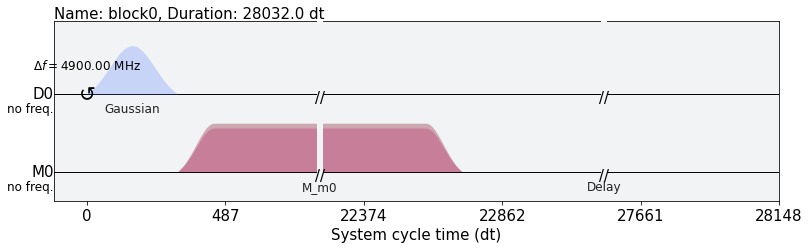

In [4]:
sample_sched.draw()

## 2. カスタムゲートを作成する例

Qiskit CircuitsのGateクラスを使って独自の量子演算ゲートを作り(ゲートの入れ物を作り)、そのゲートのパルス波をQiskit Pulseで作る(ゲートの中身を指定する)例を紹介します。つまりこの方法で、自分のカスタム演算ゲートを実行することができます。

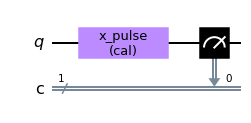

In [5]:
from qiskit import pulse
from qiskit import QuantumCircuit
from qiskit.circuit import Gate

GHz = 1.0e9 #ギガヘルツ
freq_GHz=4.95 #パルスの周波数
freq=freq_GHz*GHz #パルスの周波数(ギガヘルツ)

drive_sigma_sec = 0.075e-6 #Pulseのシグマ幅(今回は秒で指定)
drive_duration_sec = drive_sigma_sec * 8 #シグマの8倍の長さのパルス
drive_amp = 0.3 #パルスの振幅
qubit=0 #この番号の量子ビットに対して操作

# 1. カスタムゲート作成
x_pulse = Gate('x_pulse', num_qubits=1, params=[]) #ゲート名と適応する量子ビット数を指定

# 2. 1で作成したカスタムゲートを含む量子回路を作成
sample = QuantumCircuit(1, 1) #1量子ビット、1古典ビットの回路
sample.append(x_pulse, [0]) #回路にカスタムゲートを追加
sample.measure(0, 0) #測定

#3. Builder構文の定義：自分が作成したいパルスの定義を記述したscheduleクラスを作成
with pulse.build(backend) as x_schedule:
    pulse.set_frequency(freq, pulse.drive_channel(qubit)) # 周波数の定義
    pulse.play(pulse.Gaussian(duration=16*int(pulse.seconds_to_samples(drive_duration_sec)/16), 
                              # seconds_to_samples()は引数に秒を与えると、
                              # 使っているバックエンドで秒単位で経過するサンプルの数を取得。
                              amp=drive_amp, #振幅
                              sigma=pulse.seconds_to_samples(drive_sigma_sec), #長さ
                              name="x_schedule"
                             ),
               pulse.drive_channel(qubit))

#4. 3で作成したクラスを2で定義したゲートにバインド
sample.add_calibration(x_pulse, (0, ), schedule=x_schedule)

#5. 描画
sample.draw(output='mpl')

自分が定義した量子回路とバックエンドを定義してscheduleを作成して、パルスの状況を確認します。

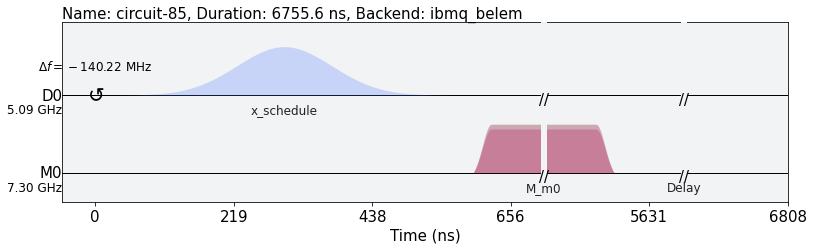

In [6]:
from qiskit import schedule

# scheduleを定義
sample_schedule = schedule(sample, backend)
sample_schedule.draw(backend=backend)

実行するには、以下を行いますが、今回はパルスに適当なパラメーターを使っているので、結果はXゲートをかけた時のように1にはなりません。


In [7]:
job = backend.run(sample)

In [8]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [9]:
print(job.result().results[0].data.counts)

{'0x0': 3985, '0x1': 15}


## 3. 周波数スイープを使って量子ビット周波数をキャリブレーションする

量子ビット周波数をキャリブレーションするために、Qiskit Pulseで周波数を変更しながら測定します。

一般的な実験室の設定は、ネットワーク・アナライザーと呼ばれるツールを使用して特定の範囲の周波数をスイープし、最大値を探すことで量子ビット周波数を見つけることができます。この測定により、量子ビット周波数の大まかな推定値が得られます。

さらに正確なキャリブレーションを行うためには、ラムゼイ・パルスシーケンスを使用します。ぜひ[Qiskitテキストブック](https://qiskit.org/textbook/ja/ch-quantum-hardware/calibrating-qubits-pulse.html)で続きを読んでみてください。

### 周波数範囲の定義
量子ビットを探すためスイープする周波数範囲を定義します。この範囲は任意に設定できますが今回は、`backend_defaults`で得られるデフォルトの推定量子ビット周波数の周りの40MHzの幅で設定します。1MHz単位で周波数を変更します。

In [10]:
import numpy as np

GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz

qubit = 0 #この番号の量子ビットに対して操作

# デフォルトの推定周波数を中心値としてスイープを行う
backend_defaults = backend.defaults()
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit] 
    # デフォルト周波数はHzで与えられるのでGHzに直すと    
print(f"量子ビット {qubit} の推定周波数は {center_frequency_Hz / GHz} GHz.")

# 推定周波数を中心に40MHzのスパンでスイープする
frequency_span_Hz = 40 * MHz
frequency_step_Hz = 1 * MHz # 1MHzの単位で

# 推定周波数より20 MHz高く、20 MHz低くスイープ
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# 実験のために周波数のnp配列をGHz単位で作成
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"スイープは {frequency_min / GHz} GHz から {frequency_max / GHz} GHz \
まで {frequency_step_Hz / MHz} MHzの幅で行います。")

量子ビット 0 の推定周波数は 5.090219685080806 GHz.
スイープは 5.070219685080806 GHz から 5.110219685080806 GHz まで 1.0 MHzの幅で行います。


この周波数をパラメーターとして、Qiskit CircuitsのParameterクラスを使って定義し、パルススケジュールを作成します。これまでと同じように、
ガウシアンパルスを使い、duration(長さ)、sigma(シグマ値)、amp(振幅)、channel(チャンネル) を設定します。

In [11]:
# サンプル数は16の倍数である必要があります
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [12]:
from qiskit import pulse                  
from qiskit.circuit import Parameter #パラメーター化回路

# 駆動パルスの設定
us = 1.0e-6 #マイクロ秒
drive_sigma_sec = 0.015*us #ガウシアンのシグマ幅(マイクロ秒で設定)
drive_duration_sec = drive_sigma_sec*8  #シグマの８倍の長さでカットする
drive_amp = 0.05 #振幅

# Parameterクラスの定義
freq = Parameter('freq')

# 自分が作成したいパルスの定義を記述したscheduleクラスを作成
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    # パルスの長さ
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
        # サンプル数は16の倍数
        # seconds_to_samples()は引数に秒を与えると、使っているバックエンドで秒単位で経過するサンプルの数を取得。
    # パルスのシグマ幅
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    # パルスのチャネル
    drive_chan = pulse.drive_channel(qubit)
    
    # パルスの周波数をParameterで設定
    pulse.set_frequency(freq, drive_chan)
    # パルスの定義：ガウス波
    pulse.play(pulse.Gaussian(duration=drive_duration, #長さ
                              sigma=drive_sigma, #シグマ幅
                              amp=drive_amp, #振幅
                              name='freq_sweep_excitation_pulse'), drive_chan)

それぞれの周波数で、その周波数の駆動パルスを量子ビットに送り、パルスの直後に測定します。

In [13]:
# カスタムゲートの作成
from qiskit.circuit import QuantumCircuit, Gate

sweep_gate = Gate("sweep", 1, [freq])

# カスタムゲートを含む量子回路を作成
qc_sweep = QuantumCircuit(1, 1)
qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)

# 上のセルで定義したパルスのscheduleクラスをカスタムゲートにバインドし、量子回路に設定
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# スイープする周波数領域(np配列)をパラメーターとして量子回路にバインド
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

自分が定義した量子回路とバックエンドを定義してscheduleを作成して、パルスの状況を確認します。

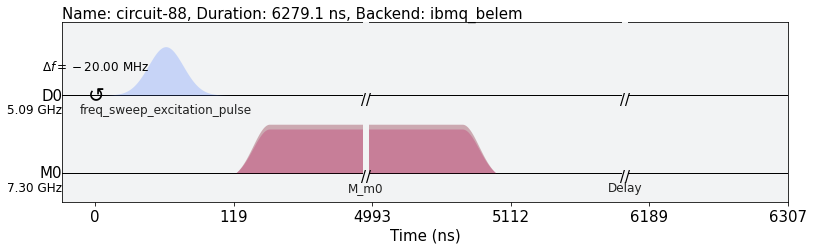

In [14]:
from qiskit import schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

各スケジュール(周波数掃引の各ポイント)を`num_shots_per_frequency`回繰り返します。

In [15]:
num_shots_per_frequency = 1024

job = backend.run(exp_sweep_circs, 
                  meas_level=1, # 較正時には1を選択
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

`job_monitor()`を使ってジョブの状態を監視します。

In [16]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


ジョブが実行が完了したら、以下を使って結果を取得できます：

In [17]:
frequency_sweep_results = job.result(timeout=120) # タイムアウトのパラメーターは120秒にセット

結果を抽出し、`matplotlib`を使ってプロットします：

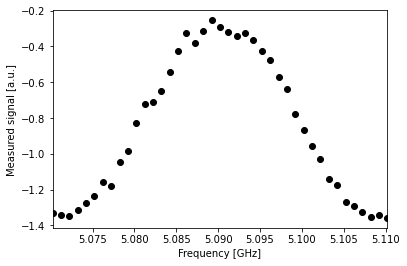

In [18]:
scale_factor = 1e-15 # データを見やすくするスケーリング
import matplotlib.pyplot as plt
sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # i番目の実験から結果を得る
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # この実験から`qubit`の結果を得る
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # スイープ値の実数部分をプロット
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

上図のように、中心付近のピークは量子ビットの周波数の位置に対応しています。ピーク周波数の値を取得するために、値を共鳴応答曲線に適合させます。これは通常、ローレンツ分布の形です。

In [19]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [20]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 5.3, 1, -2] # フィッティングの初期パラメーター
                                )

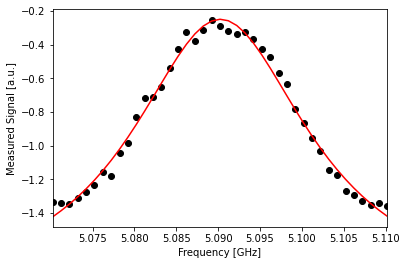

In [21]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [22]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"推定量子ビット周波数を"
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz からto {round(rough_qubit_frequency/GHz, 5)} GHz に更新しました・")

推定量子ビット周波数を5.09022 GHz からto 5.09027 GHz に更新しました・


この先の更なる周波数のキャリブレーションについては、Qiskitテキストブックの[「Qiskit Pulseによる量子ビットの較正」](https://qiskit.org/textbook/ch-quantum-hardware/calibrating-qubits-pulse.html)の章を参照してください。

In [23]:
import qiskit.tools.jupyter
%qiskit_version_table